The idea is to explore the feasibility of doing RL for trading, end to end:

    - Split the df in half, explore only xlm
    - With the info of the features we have (all), run, trading strategy, and use profit as reward
    - Validate on the other half
    
NAH!!

Optuna optim / Bayesian with take profit/stop loss

In [18]:
import numba
from typing import List, Tuple
import numpy as np
import optuna
@numba.jit(nopython=True, parallel=False)
def backtest(
    indexes: np.array,
    open_values: np.array,
    take_profit_pct: float = 0.04,
    stop_loss_pct:float=0.04,
    buy_again_pct:float=0.00,
    security_factor:float=0.0024,
    fee: float = 0.0016,
)->List[Tuple[int, int, float, int]]:
    """Other type of backtest that does not depend on any signal for bying, just percentages"""
    list_action = []
    # buy 0 sell 1
    next_action: int = 0
    previous_price: float = 1e5 # first it will buy
    # comments 0= predicted buy, 1 take_profit, 2 stop_loss
    
    for index, (i, open_value) in enumerate(zip(indexes, open_values)):
        # sell 1, buy 0
        if buy_again_pct<(1-open_value/previous_price) and not next_action:
            cost = -open_values[index]*(1+fee+security_factor)
            list_action.append((i, next_action, cost, 0))
            previous_price = open_value
            next_action = 1
            
        elif (open_value>(1+take_profit_pct)*previous_price) and next_action:
            cost = open_values[index]*(1-fee-security_factor)
            list_action.append((i, next_action, cost, 1))
            previous_price = open_value
            next_action = 0
        elif (open_value<(1-stop_loss_pct)*previous_price) and next_action:
            cost = open_values[index]*(1-fee-security_factor)
            list_action.append((i, next_action, cost, 2))
            previous_price = open_value
            next_action = 0 
    if len(list_action)>0:
        if (indexes[-1] == list_action[-1][0]) and (list_action[-1][1]==1):
            # remove if there is a last sell in the last interval because we do not now the next open price
            # weird error. Example with bateur where the cost using the open price is set to 500 for no reason
            list_action.remove(list_action[-1])
                
        if list_action[-1][1]==0:
            # remove if last is also a buy
            list_action.remove(list_action[-1])

    return list_action

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
df_all = pd.read_feather("../data/training/training_all_crypto_14_12_2021.feather")
#df = df_all[df_all.pair_name=="xlmeur"].copy()
df = df_all.copy()

In [7]:
#actions = backtest(indexes=df.time.values, open_values=df.open.values)

In [8]:
#actions_df = pd.DataFrame(actions, columns=["time", "action", "cost", "comment"])
#pct_profit = actions_df.cost.sum()/df.open.mean()
#pct_hist = df.iloc[-1].open/df.iloc[1].open-1
#metric = pct_profit-pct_hist
#print(pct_profit, pct_hist, metric)

In [15]:
sampler = optuna.samplers.TPESampler(multivariate=True,seed=1)
def objective(trial):
    # 1. Suggest values of the hyperparameters using a trial object.
    param = {
        'take_profit_pct': trial.suggest_float('take_profit_pct', 1e-8, 0.05),
        'stop_loss_pct': trial.suggest_float('stop_loss_pct', 1e-8, 0.05),
        'buy_again_pct': trial.suggest_float('buy_again_pct', 1e-8, 0.05),
        
    }
    list_metric = []
    number_actions = []
    for name, df_group in df.groupby("pair_name"):
        #print(name)
        actions = backtest(
            indexes= df_group.time.values,
            open_values=df_group.open.values,
            **param
        )
        actions_df = pd.DataFrame(actions, columns=["index", "action", "cost", "comment"])
        number_actions.append(actions_df.shape[0])
        pct_profit = actions_df["cost"].sum()/df_group["open"].mean()
        pct_hist = df_group.tail(1).open.values[0]/df_group.head(1).open.values[0]-1
        profit = pct_profit-pct_hist
        list_metric.append(profit)#-hist_ratio)

        
    
    
    #print(param)
    #print(list_metric)
    mean_metrics=np.array(list_metric).mean()
    #print(mean_metrics)
    #if mean_metrics>20:
    #    print("-"*40)
    #    print(actions)
    #    print(profit, hist_ratio)
    #    print(list_metric)
    return mean_metrics #* np.array(number_actions).mean()/1000

# 3. Create a study object and optimize the objective function.
optuna.logging.set_verbosity("INFO")
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=100)

/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/optuna/samplers/_tpe/sampler.py:263: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2022-04-02 20:18:14,505] A new study created in memory with name: no-name-778818ab-1c0d-465f-a4e0-a18b3b8163fe
[I 2022-04-02 20:18:15,710] Trial 0 finished with value: -0.4789634502602703 and parameters: {'take_profit_pct': 0.020851106064908656, 'stop_loss_pct': 0.036016227468862974, 'buy_again_pct': 5.728739723496158e-06}. Best is trial 0 with value: -0.4789634502602703.
[I 2022-04-02 20:18:16,301] Trial 1 finished with value: -0.1806889147642435 and parameters: {'take_profit_pct': 0.015116635608266262, 'stop_loss_pct': 0.007337803073296744, 'buy_again_pct': 0.004616938815053942}. Best is trial 1 with value: -0.1806889147642435.
[I 2022-04-02 20:18:16,891] Trial 2 finished with value: -0.03044963055982094 and parameters: {'take_profit

In [16]:
study.best_params

{'take_profit_pct': 0.049583199651452414,
 'stop_loss_pct': 0.048701130079383474,
 'buy_again_pct': 0.03435696160732871}

0.2056299982650985 -0.4235850550272613 0.6292150532923598
          time  action      cost  comment
0   1632402300       0 -1.892669        0
1   1632440460       1  1.971049        1
2   1632474900       0 -1.911424        0
3   1632480600       1  1.802512        2
4   1632849300       0 -1.753738        0
5   1632912420       1  1.826807        1
6   1632930780       0 -1.776007        0
7   1633075320       1  1.849572        1
8   1634033820       0 -1.800094        0
9   1634161020       1  1.875687        1
10  1634502060       0 -1.823192        0
11  1634776260       1  1.899610        1
12  1634857140       0 -1.848011        0
13  1635321780       1  1.733750        2
14  1635322140       0 -1.637726        0
15  1635323700       1  1.710341        1
16  1635326940       0 -1.662137        0
17  1635333300       1  1.731087        1
18  1635352200       0 -1.682119        0
19  1635411180       1  1.752021        1
20  1635446400       0 -1.686719        0
21  1635916740    

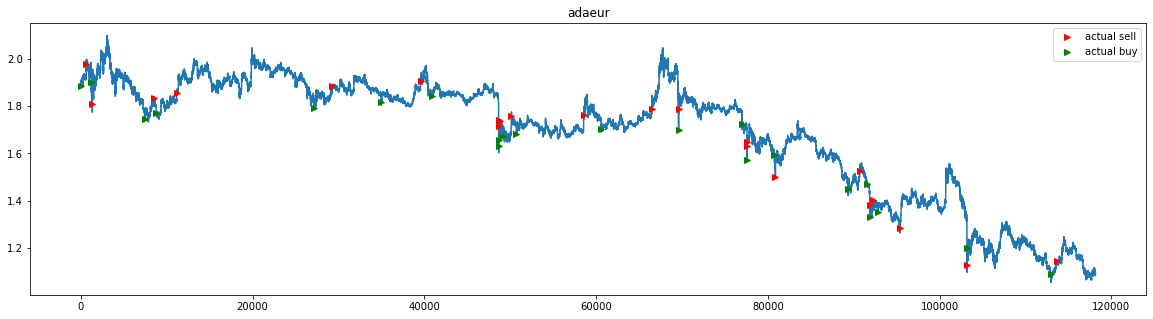

0.13195516944769511 -0.2612337070147466 0.3931888764624417
          time  action      cost  comment
0   1632402300       0 -1.607846        0
1   1632406320       1  1.677682        1
2   1632456780       0 -1.631339        0
3   1632474960       1  1.533840        2
4   1632475680       0 -1.485127        0
5   1632492300       1  1.546539        1
6   1632554880       0 -1.504594        0
7   1632617700       1  1.419669        2
8   1632641880       0 -1.375480        0
9   1632649620       1  1.433632        1
10  1632838800       0 -1.389998        0
11  1632891300       1  1.448592        1
12  1632929940       0 -1.408582        0
13  1633084800       1  1.469478        1
14  1634008020       0 -1.428521        0
15  1634048580       1  1.488900        1
16  1637057400       0 -1.417648        0
17  1637060580       1  1.478682        1
18  1637145300       0 -1.437296        0
19  1637196900       1  1.498472        1
20  1637916600       0 -1.456854        0
21  1638039420   

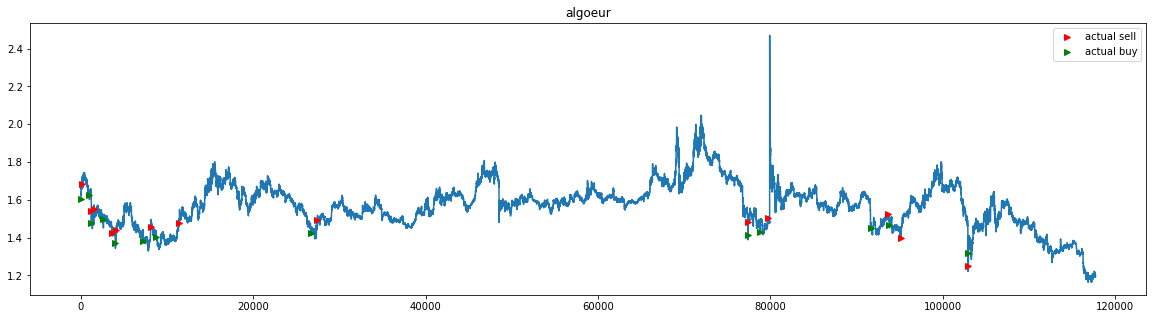

-0.004377415790324342 0.5622465323927341 -0.5666239481830585
         time  action      cost  comment
0  1632402300       0 -0.589207        0
1  1632475020       1  0.552870        2
2  1632481560       0 -0.537522        0
3  1632516960       1  0.560399        1
4  1632558660       0 -0.544981        0
5  1632642600       1  0.512940        2
6  1632872940       0 -0.498627        0
7  1632928080       1  0.519185        1
8  1632946020       0 -0.505303        0
9  1632966060       1  0.526515        1
-0.004377415790324342


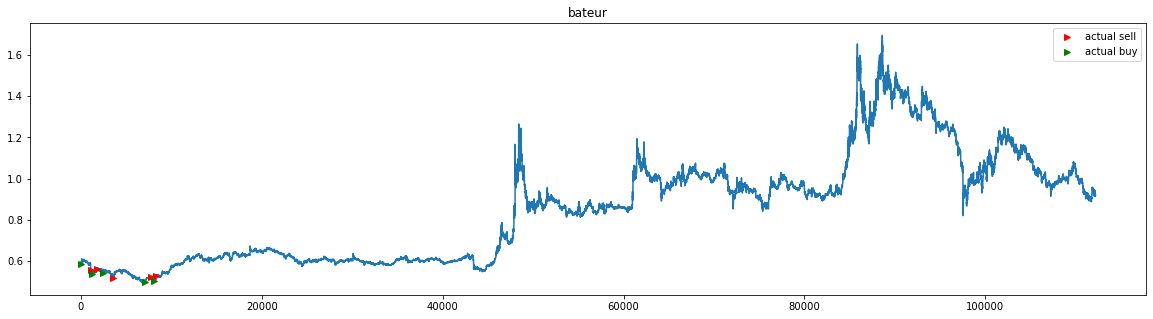

-0.15778652276115218 -0.16648814078041307 0.008701618019260893
          time  action       cost  comment
0   1632402300       0 -459.27980        0
1   1632475680       1  431.36760        2
2   1632481560       0 -419.69208        0
3   1632515880       1  437.71212        1
4   1632641760       0 -425.76628        0
5   1633075380       1  444.56460        1
6   1638593760       0 -429.39072        0
7   1638594900       1  405.09312        2
8   1638595320       0 -392.24272        0
9   1638595500       1  350.54220        2
10  1638595560       0 -335.85808        0
11  1638595680       1  314.19816        2
-0.15778652276115218


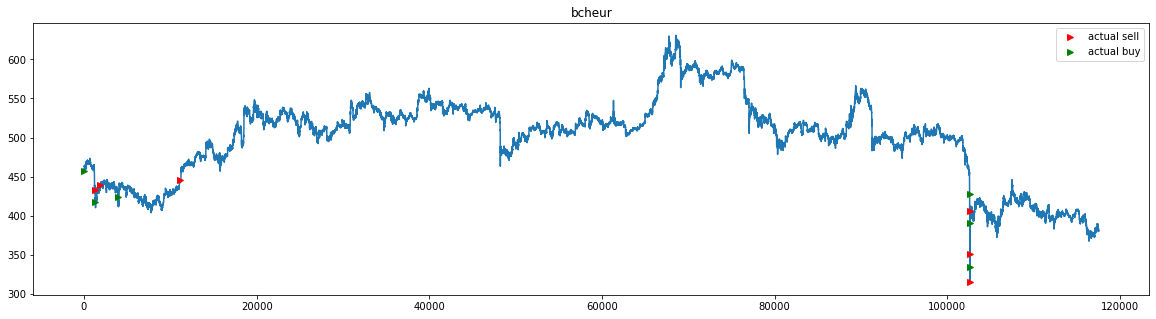

0.0005428330778469391 -0.43907887953256575 0.43962171261041266
          time  action       cost  comment
0   1632402300       0 -292.11380        0
1   1632409680       1  304.74612        1
2   1632474960       0 -294.23224        0
3   1632481920       1  273.53148        2
4   1632642720       0 -266.24072        0
5   1632648180       1  278.37204        1
6   1632956400       0 -269.48364        0
7   1632957600       1  253.63140        2
8   1632958440       0 -246.11052        0
9   1632959100       1  256.83852        1
10  1632967260       0 -249.91568        0
11  1632976500       1  261.05160        1
12  1632985740       0 -254.08228        0
13  1633031460       1  265.97184        1
14  1633507740       0 -258.78100        0
15  1633533960       1  269.82636        1
16  1633565700       0 -262.29500        0
17  1633615800       1  273.89004        1
18  1633900620       0 -266.22064        0
19  1634008440       1  251.12148        2
20  1637763780       0 -244.42380 

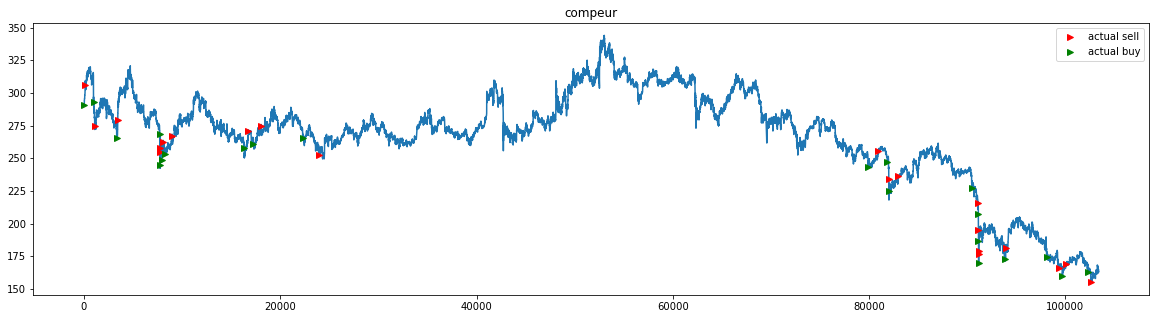

0.0682272191608569 0.2752482732552144 -0.2070210540943575
         time  action        cost  comment
0  1632402300       0 -2630.90168        0
1  1632475020       1  2463.25740        2
2  1632481560       0 -2394.05808        0
3  1632493800       1  2493.60552        1
4  1632558840       0 -2420.67412        0
5  1632564480       1  2521.28436        1
6  1632582180       0 -2448.46484        0
7  1632649800       1  2552.21016        1
8  1632813840       0 -2483.25344        0
9  1632973860       1  2586.18372        1
0.0682272191608569


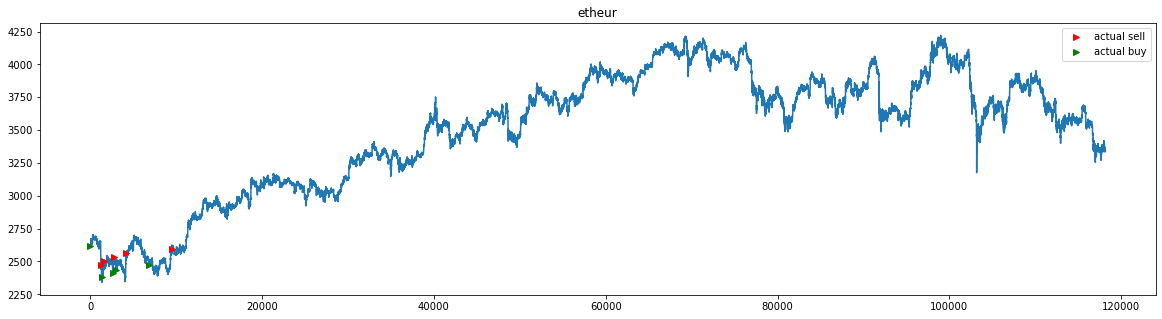

-0.06471148847191342 -0.09503348744207585 0.030321998970162425
          time  action      cost  comment
0   1632402300       0 -0.188192        0
1   1632475560       1  0.177432        2
2   1632479760       0 -0.172101        0
3   1632515340       1  0.179280        1
4   1632623220       0 -0.174365        0
5   1633084740       1  0.181870        1
6   1637915220       0 -0.174786        0
7   1637936700       1  0.182021        1
8   1638066840       0 -0.176905        0
9   1638146160       1  0.184200        1
10  1638415260       0 -0.179215        0
11  1638434400       1  0.189466        1
12  1638469860       0 -0.184406        0
13  1638562500       1  0.173862        2
14  1638593580       0 -0.168707        0
15  1638594180       1  0.157078        2
16  1638594240       0 -0.147869        0
17  1638595380       1  0.136452        2
18  1638595500       0 -0.129856        0
19  1638595620       1  0.121747        2
-0.06471148847191342


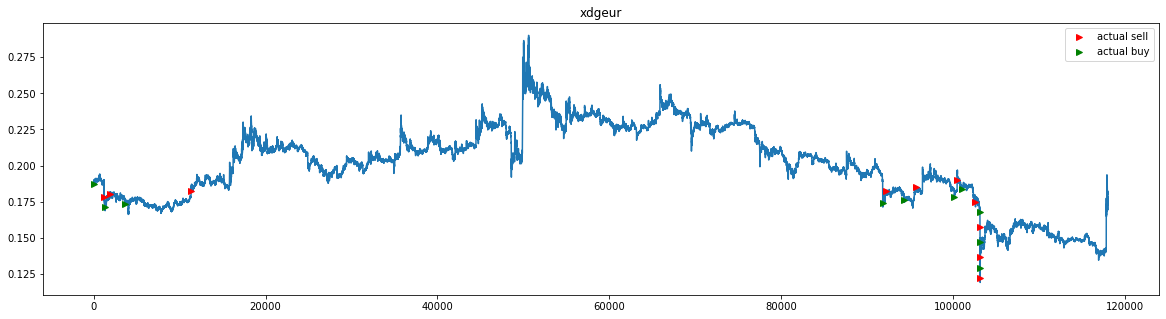

-0.05885305294090329 -0.07322601220299829 0.014372959262095003
         time  action      cost  comment
0  1632401460       0 -0.250703        0
1  1632479520       1  0.236502        2
2  1632641100       0 -0.229947        0
3  1632706500       1  0.240036        1
4  1632754740       0 -0.233479        0
5  1632849120       1  0.220289        2
-0.05885305294090329


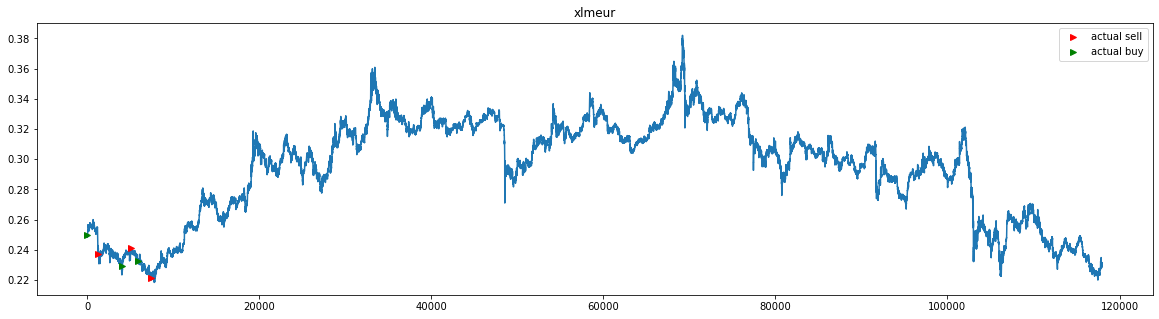

-0.006775913940201881 -0.15941872981700744 0.15264281587680556
          time  action      cost  comment
0   1632402300       0 -0.839294        0
1   1632475500       1  0.789290        2
2   1632482100       0 -0.767056        0
3   1632515640       1  0.798682        1
4   1632642000       0 -0.775841        0
5   1632657960       1  0.808692        1
6   1632838800       0 -0.786624        0
7   1632920580       1  0.824549        1
8   1632937440       0 -0.801523        0
9   1633074900       1  0.835226        1
10  1638067080       0 -0.811302        0
11  1638136860       1  0.844897        1
12  1638561780       0 -0.820870        0
13  1638593640       1  0.758952        2
14  1638593760       0 -0.722187        0
15  1638594300       1  0.672300        2
16  1638595320       0 -0.653724        0
17  1638595560       1  0.603496        2
18  1638595620       0 -0.584007        0
19  1638595920       1  0.620169        1
-0.006775913940201881


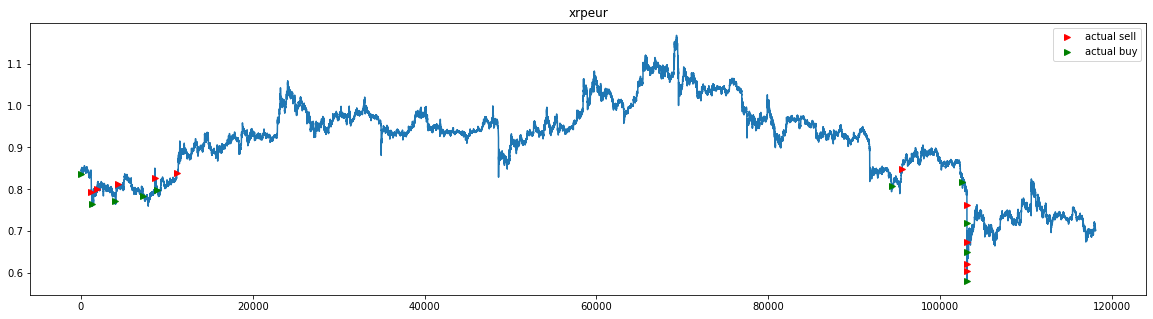

In [17]:
for name, grouped_df in df.groupby("pair_name"):
    
    actions = backtest(indexes=grouped_df.time.values, open_values=grouped_df.open.values, **study.best_params)
    actions_df = pd.DataFrame(actions, columns=["time", "action", "cost", "comment"])
    pct_profit = actions_df.cost.sum()/grouped_df.open.mean()
    pct_hist = grouped_df.iloc[-1].open/grouped_df.iloc[1].open-1
    metric = pct_profit-pct_hist
    print(pct_profit, pct_hist, metric)
    actions_df = pd.DataFrame(actions, columns=["time", "action", "cost", "comment"])
    df_backtest = grouped_df.merge(actions_df, how="left", on="time")
    print(actions_df)
    print(actions_df.cost.sum()/df_backtest.open.mean())
    plt.figure(figsize=(20,5))
    plt.plot(df_backtest.open)
    plt.plot(df_backtest[df_backtest.action==1].open, ">r", label="actual sell")
    plt.plot(df_backtest[df_backtest.action==0].open, ">g", label="actual buy")
    plt.legend()
    plt.title(name)
    plt.show()

In [30]:
df_backtest

,index,Unnamed: 0,date,time,open,high,low,close,vwap,volume,...,feature_domain_33,feature_domain_34,feature_domain_35,feature_domain_36,feature_domain_37,type,pair_name,action,cost,comment
0,0,0,2021-09-23 12:51:00,1632401460,0.249704,0.249974,0.249701,0.249974,0.249742,1282.799768,...,0.006631,-0.002234,-0.018154,-0.026920,-0.006311,training,xlmeur,NaN,NaN,NaN
1,1,1,2021-09-23 12:52:00,1632401520,0.249283,0.249283,0.249283,0.249283,0.249283,248.905328,...,0.005814,-0.003916,-0.019883,-0.028561,-0.007292,training,xlmeur,NaN,NaN,NaN
2,2,2,2021-09-23 12:53:00,1632401580,0.249283,0.249283,0.249283,0.249283,0.000000,0.000000,...,0.003417,-0.003498,-0.017983,-0.028561,-0.007292,training,xlmeur,NaN,NaN,NaN
3,3,3,2021-09-23 12:54:00,1632401640,0.249283,0.249283,0.249283,0.249283,0.000000,0.000000,...,0.003417,-0.003498,-0.017716,-0.028561,-0.006049,training,xlmeur,NaN,NaN,NaN
4,4,4,2021-09-23 12:55:00,1632401700,0.248767,0.248767,0.248767,0.248767,0.248767,872.247000,...,0.001215,-0.005560,-0.018221,-0.030571,-0.006787,training,xlmeur,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117943,117943,117943,2021-12-14 14:21:00,1639491660,0.231180,0.231180,0.231180,0.231180,0.231180,3826.584692,...,0.001942,0.007654,0.017836,0.023219,0.035303,validation_unseen,xlmeur,NaN,NaN,NaN
117944,117944,117944,2021-12-14 14:22:00,1639491720,0.231369,0.231369,0.231369,0.231369,0.231369,1294.565659,...,0.006101,0.009296,0.018668,0.024133,0.036033,validation_unseen,xlmeur,NaN,NaN,NaN
117945,117945,117945,2021-12-14 14:23:00,1639491780,0.231365,0.231365,0.231365,0.231365,0.231365,2200.000000,...,0.001337,0.010398,0.018516,0.024274,0.035885,validation_unseen,xlmeur,NaN,NaN,NaN
117946,117946,117946,2021-12-14 14:24:00,1639491840,0.231066,0.231127,0.230969,0.230969,0.231016,6072.458801,...,-0.003373,0.009922,0.017128,0.022294,0.034954,validation_unseen,xlmeur,NaN,NaN,NaN


           time  action      cost  comment
0    1632401460       0 -0.250703        0
1    1632441900       1  0.258959        1
2    1632442020       0 -0.261024        0
3    1632474180       1  0.248548        2
4    1632474240       0 -0.250092        0
..          ...     ...       ...      ...
179  1639401660       1  0.230315        2
180  1639404480       0 -0.232159        0
181  1639462860       1  0.220933        2
182  1639462980       0 -0.221777        0
183  1639482780       1  0.228931        1

[184 rows x 4 columns]
-0.5268773979852133


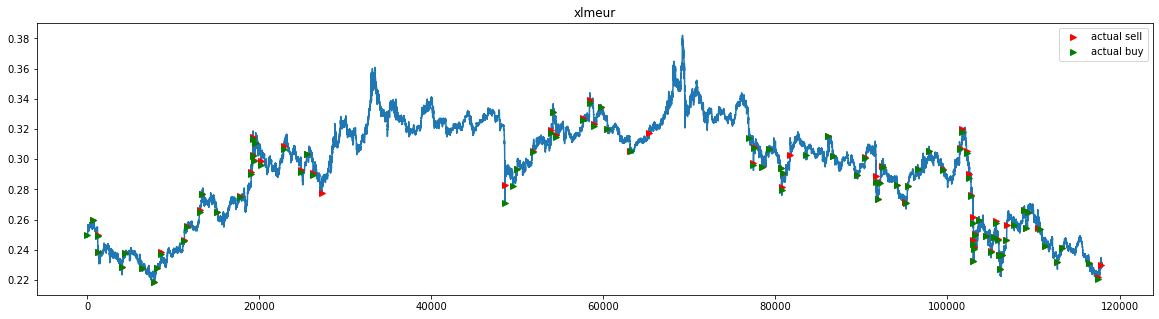

In [44]:
actions_df = pd.DataFrame(actions, columns=["time", "action", "cost", "comment"])
df_backtest = df_xlm.merge(actions_df, how="left", on="time")
print(actions_df)
print(actions_df.cost.sum()/df_backtest.open.mean())
plt.figure(figsize=(20,5))
plt.plot(df_backtest.open)
plt.plot(df_backtest[df_backtest.action==1].open, ">r", label="actual sell")
plt.plot(df_backtest[df_backtest.action==0].open, ">g", label="actual buy")
plt.legend()
plt.title("xlmeur")
plt.show()


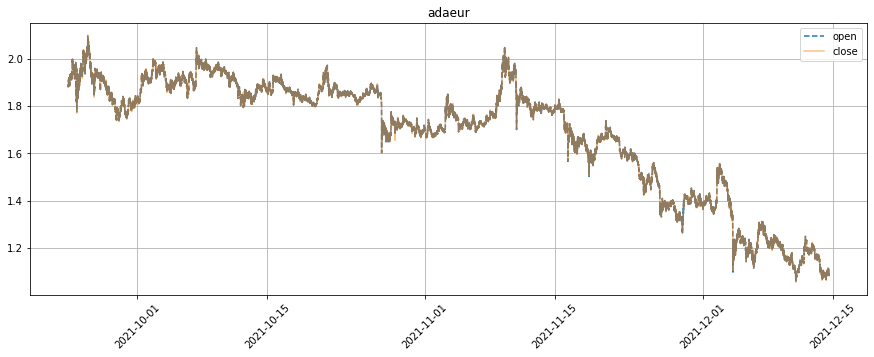

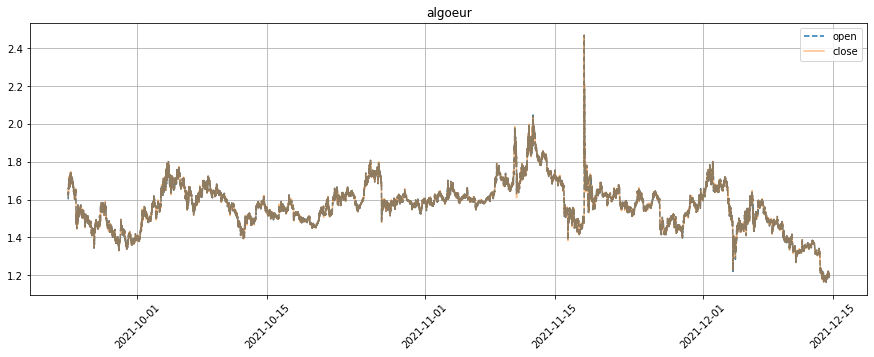

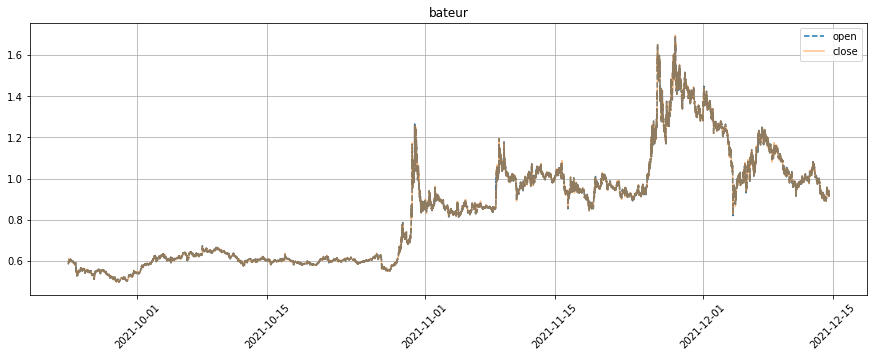

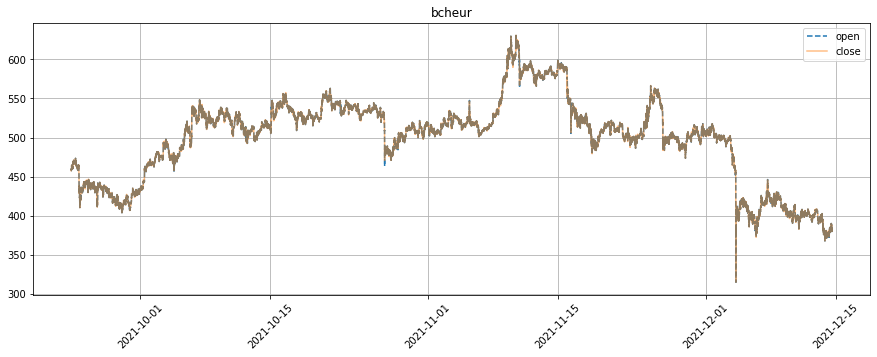

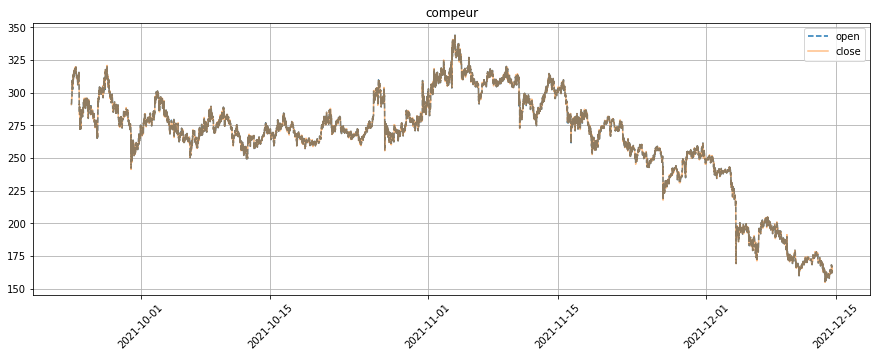

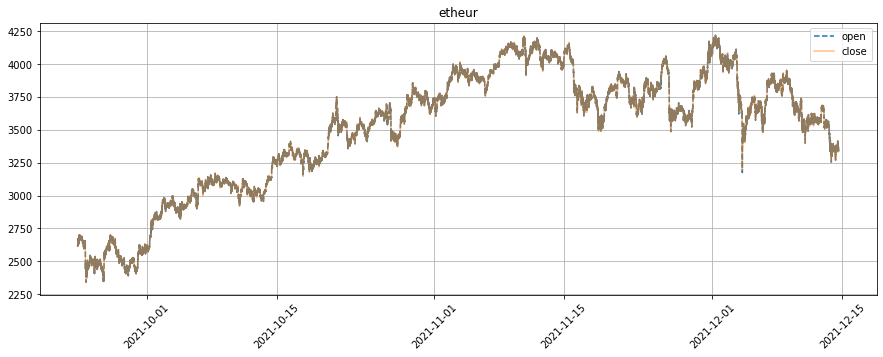

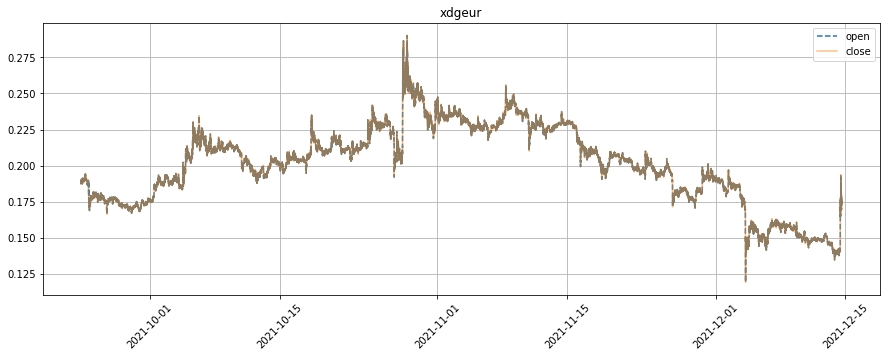

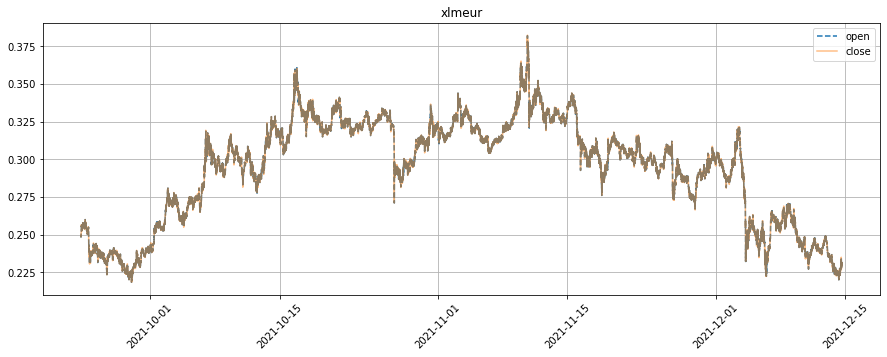

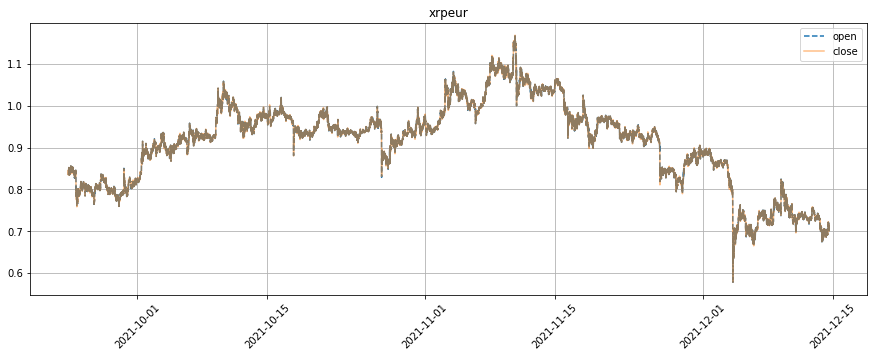

In [27]:
for name, grouped_df in df_all.groupby("pair_name"):
    plt.figure(figsize=(15,5))
    plt.plot(grouped_df.date, grouped_df.open,"--", label="open", alpha=1)
    plt.plot(grouped_df.date, grouped_df.close,label="close", alpha=0.5)
    plt.grid()
    
    plt.xticks(rotation=45)
    plt.legend()
    plt.title(name)
    plt.show()

In [11]:
df_train = df_xlm.loc[:round(len(df)/2)].copy()
df_val = df_xlm.loc[round(len(df)/2):].copy()

In [12]:
df_train

,index,Unnamed: 0,date,time,open,high,low,close,vwap,volume,...,feature_domain_30,feature_domain_31,feature_domain_32,feature_domain_33,feature_domain_34,feature_domain_35,feature_domain_36,feature_domain_37,type,pair_name
0,0,0,2021-09-23 12:51:00,1632401460,0.249704,0.249974,0.249701,0.249974,0.249742,1282.799768,...,0.001279,0.005865,0.000978,0.006631,-0.002234,-0.018154,-0.026920,-0.006311,training,xlmeur
1,1,1,2021-09-23 12:52:00,1632401520,0.249283,0.249283,0.249283,0.249283,0.249283,248.905328,...,-0.000409,0.003183,0.003648,0.005814,-0.003916,-0.019883,-0.028561,-0.007292,training,xlmeur
2,2,2,2021-09-23 12:53:00,1632401580,0.249283,0.249283,0.249283,0.249283,0.000000,0.000000,...,-0.000409,0.002614,0.003640,0.003417,-0.003498,-0.017983,-0.028561,-0.007292,training,xlmeur
3,3,3,2021-09-23 12:54:00,1632401640,0.249283,0.249283,0.249283,0.249283,0.000000,0.000000,...,-0.001590,0.002614,0.001434,0.003417,-0.003498,-0.017716,-0.028561,-0.006049,training,xlmeur
4,4,4,2021-09-23 12:55:00,1632401700,0.248767,0.248767,0.248767,0.248767,0.248767,872.247000,...,-0.003206,0.000539,0.000873,0.001215,-0.005560,-0.018221,-0.030571,-0.006787,training,xlmeur
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58970,58970,58970,2021-11-03 14:13:00,1635948780,0.324982,0.325504,0.324982,0.325504,0.325165,1217.798871,...,0.005943,0.009277,-0.000283,-0.002456,-0.011612,-0.039191,-0.034610,-0.040765,training,xlmeur
58971,58971,58971,2021-11-03 14:14:00,1635948840,0.325608,0.325608,0.325437,0.325437,0.325520,591.038609,...,0.009002,0.011221,0.001643,-0.001885,-0.011473,-0.037360,-0.033552,-0.039275,training,xlmeur
58972,58972,58972,2021-11-03 14:15:00,1635948900,0.325280,0.325280,0.325280,0.325280,0.325280,2300.000000,...,0.010008,0.008999,0.000692,-0.003102,-0.013502,-0.038040,-0.033742,-0.040223,training,xlmeur
58973,58973,58973,2021-11-03 14:16:00,1635948960,0.325724,0.325850,0.325724,0.325850,0.325751,158.936514,...,0.008543,0.010765,0.002058,-0.003055,-0.010297,-0.034892,-0.033216,-0.038913,training,xlmeur


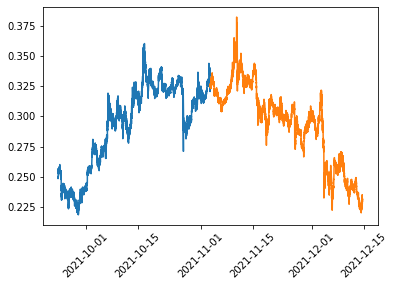

In [19]:
plt.plot(df_train.date, df_train.close)
plt.plot(df_val.date, df_val.close)
plt.xticks(rotation=45)
plt.show()